In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats

In [16]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df = df[df.index.year.isin(np.arange(2015,2019))]

X_test_scaled = np.load("/glade/work/hpzhang/LCC_pred/data/X_test_scaled.npy")

pred_XGB    = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/y_pred_XGB.npy')
shap_values = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/shap_values.npy')
shap_data   = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/shap_data.npy')

In [3]:
df.head()

,lat,lon,lsm,LCF,T1000,T700,TH1000,TH850,TH700,RH1000,...,LH,SH,SST,Tadv,AOD,dQ,LTS,EIS,ECTEI,ELF
time,,,,,,,,,,,,,,,,,,,,,
2015-01-15,-59.5,0.5,0.0,0.463868,273.248932,257.640778,273.248932,276.122772,285.309723,74.363846,...,-27.085648,-4.329421,273.818970,0.004144,0.1830,0.001957,12.060791,5.536515,4.415848,0.842661
2015-01-15,-59.5,1.5,0.0,0.463868,273.248932,257.677979,273.248932,276.148712,285.350922,74.302193,...,-26.748310,-4.402477,273.810089,0.017093,0.1500,0.001953,12.101990,5.572093,4.453444,0.843229
2015-01-15,-59.5,2.5,0.0,0.429262,273.243439,257.717896,273.243439,276.157379,285.395111,74.627144,...,-25.706528,-3.955046,273.756317,-0.045310,0.1405,0.001963,12.151672,5.616665,4.492636,0.847486
2015-01-15,-59.5,3.5,0.0,0.429262,273.237915,257.761963,273.237915,276.161713,285.443909,74.877113,...,-25.131065,-3.863727,273.736786,-0.162998,0.1455,0.001953,12.205994,5.665254,4.546604,0.851414
2015-01-15,-59.5,4.5,0.0,0.427947,273.237915,257.800537,273.237915,276.212219,285.486633,75.538681,...,-25.160833,-4.320301,273.761627,-0.077789,0.1295,0.001952,12.248718,5.702139,4.584386,0.859509


In [4]:
df_new = pd.DataFrame({'lat':df['lat'],
                       'lon':df['lon'],
                       'LCF':df['LCF'],
                       'EIS':df['EIS'],
                       'ECTEI':df['ECTEI'],
                       'ELF':df['ELF'],
                       'y_pred_XGB':pred_XGB,
                      }, index=df.index)

In [5]:
df_new['season'] = ''
df_new.loc[df_new.index.month.isin([3,4,5]),   'season']='MAM'
df_new.loc[df_new.index.month.isin([6,7,8]),   'season']='JJA'
df_new.loc[df_new.index.month.isin([9,10,11]), 'season']='SON'
df_new.loc[df_new.index.month.isin([12,1,2]),  'season']='DJF'

lat = df_new.lat
lon = df_new.lon

OCN_index = (lat>=-60)&(lat<=60)
SO_index  = (lat>=-60)&(lat<-50)
SEP_index = ((lat>=-20)&(lat<-10)) & ((lon>=270)&(lon<280))
SEA_index = ((lat>=-20)&(lat<-10)) & ((lon>=0)&(lon<10))
SEI_index = ((lat>=-35)&(lat<-25)) & ((lon>=95)&(lon<105))
NEP_index = ((lat>=20)&(lat<30))   & ((lon>=230)&(lon<240))
NEA_index = (lat>=15)&(lat<25)     & ((lon>=325)&(lon<335))
NA_index  = (lat>=50)&(lat<60)     & ((lon>=315)&(lon<325))
NP_index  = (lat>=40)&(lat<50)     & ((lon>=170)&(lon<180))

df_new['regs'] = np.NaN
df_new.loc[SO_index,  'regs']='SO'
df_new.loc[SEP_index, 'regs']='SEP'
df_new.loc[SEA_index, 'regs']='SEA'
df_new.loc[SEI_index, 'regs']='SEI'
df_new.loc[NEP_index, 'regs']='NEP'
df_new.loc[NEA_index, 'regs']='NEA'
df_new.loc[NA_index,  'regs']='NA'
df_new.loc[NP_index,  'regs']='NP'

df_new['season'] = pd.Categorical(df_new['season'], ['DJF', 'MAM', 'JJA', 'SON'])
df_new['regs']   = pd.Categorical(df_new['regs'],   ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO'])

In [6]:
lab = df.columns[6:-3].drop(['SST', 'AOD'])
shap_values = pd.DataFrame(shap_values, columns=lab)
shap_data   = pd.DataFrame(shap_data, columns=lab)

In [7]:
shap_abs_mean   = shap_values.applymap(abs).mean().sort_values(ascending=False)
shap_values_new = shap_values[shap_abs_mean.index]
shap_data_new   = shap_data[shap_abs_mean.index]
shap_data_unscaled = df[shap_abs_mean.index]

In [8]:
shap_abs_mean.index

Index(['TH1000', 'PWV', 'TH850', 'LTS', 'RH850', 'OMEGA500', 'SH', 'Q1000',
       'U1000', 'RH1000', 'Q850', 'Q700', 'dQ', 'LH', 'U700', 'TH700', 'RH700',
       'OMEGA700', 'Tadv'],
      dtype='object')

In [9]:
labs = [r'$\theta_{1000}$', r'$\theta_{850}$', r'$\theta_{700}$',
        r'RH$_{1000}$', r'RH$_{850}$', r'RH$_{700}$',
        r'$q_{1000}$', r'$q_{850}$', r'$q_{700}$',
        r'$U_{1000}$', r'$U_{700}$',
        r'$\omega_{500}$', r'$\omega_{700}$', 
        'PWV', 'LHF', 'SHF', 
        r'$T_{adv}$', r'$\delta$$q$',
        'LTS']

labs_units = [r'$\theta_{1000}$ (K)', r'$\theta_{850}$ (K)', r'$\theta_{700}$ (K)',
              r'RH$_{1000}$ (%)', r'RH$_{850}$ (%)', r'RH$_{700}$ (%)',
              r'$q_{1000}$ (kg/kg)', r'$q_{850}$ (kg/kg)', r'$q_{700}$ (kg/kg)',
              r'$U_{1000}$ (m/s)', r'$U_{700}$ (m/s)',
              r'$\omega_{500}$ (Pa/s)', r'$\omega_{700}$ (Pa/s)', 
              'PWV (kg/m$^2$)', 'LHF (W/$m^2$)', 'SHF (W/$m^2$)', 
              r'$T_{adv}$ (K/day)', r'$\delta$$q$ (kg/kg)',
              'LTS (K)']

labels = pd.DataFrame({'labs': labs, 'labs_units': labs_units},index=lab.values)

In [10]:
labels_new = labels.reindex(shap_abs_mean.index.values)

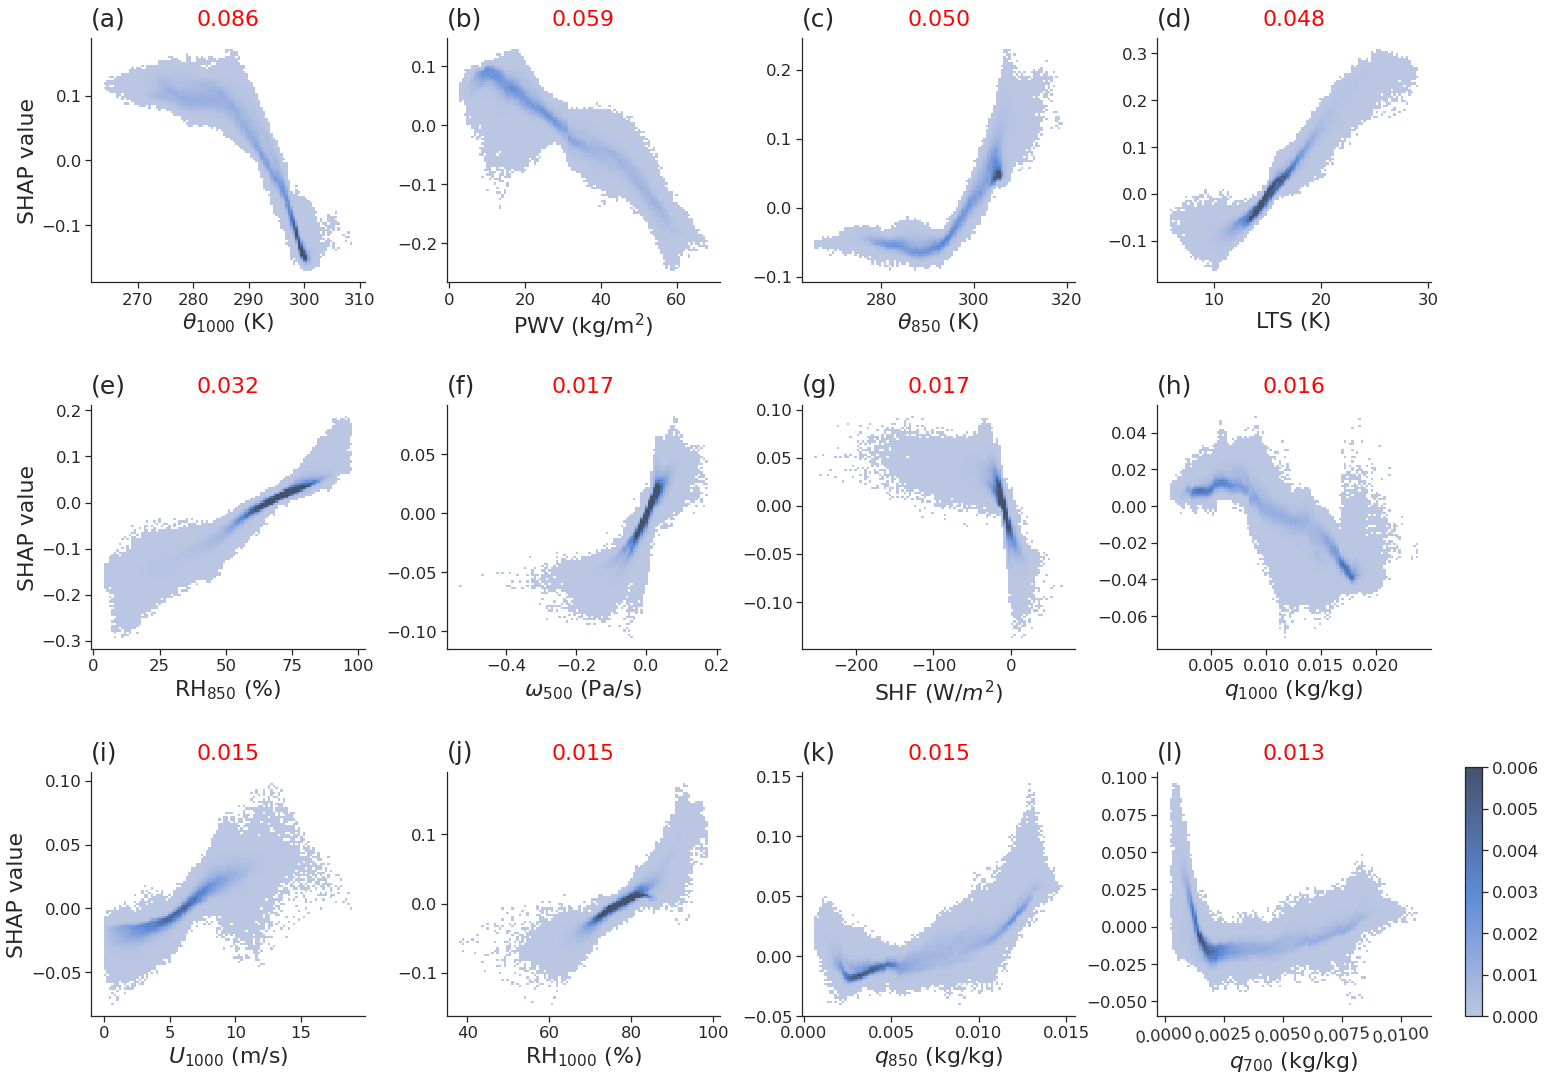

In [11]:

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.5)

fig, axes = plt.subplots(3, 4, figsize=[24, 18])

ti = 'abcdefghijkl'
for i, ax in enumerate(axes.flat):
      g = sns.histplot(x=shap_data_unscaled.values[:,i], y=shap_values_new.values[:,i],
                       ax=ax,
                       bins=100,
                       vmin=0,
                       vmax=0.006,
                       stat='probability',
                       common_norm=False,
                       cbar=False)
      ax.set_xlabel(labels_new.labs_units[i], fontsize=22)
      if (i%4==0):
        ax.set_ylabel('SHAP value', fontsize=22)
        
      ax.annotate('('+ti[i]+')', xy=(0.00, 1.05), xycoords='axes fraction', fontsize=25)
      ax.annotate('{0:.3f}'.format(shap_abs_mean[i]), xy=(0.5, 1.05), xycoords='axes fraction', fontsize=22, 
                   ha="center",
                   c='red')

ax.tick_params(axis='x', rotation=5)

pos1 = ax.get_position()
x0   = pos1.x0
y0   = pos1.y0
hgt  = pos1.height
wth  = pos1.width

cb_ax = fig.add_axes([x0+wth+0.02, y0, 0.01, hgt-0.03])
fig.colorbar(ax.get_children()[0], cax=cb_ax, orientation="vertical")

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [12]:
regs = [NA_index, NP_index, NEP_index, NEA_index, SEP_index, SEA_index, SEI_index, SO_index] # OCN_index
regs_names = ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO'] # ALL

In [15]:
import pickle
import shap

### load model ###
file_name = "/glade/work/hpzhang/LCC_pred/data/xgb_reg.pkl"
xgb_model = pickle.load(open(file_name, "rb"))

# get the relative percentage of shape_value_albsolute_mean for each feature
def get_shapvalues(regs):
    tmp = pd.DataFrame(X_test_scaled, columns=lab)
    #X_sampled = tmp.sample(1000, random_state=10)
    X_sampled = tmp[regs.values]

    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_sampled)
    
    shap_values_abs_mean = pd.DataFrame(shap_values.values, columns=lab).applymap(abs).mean()
    shap_values_abs_mean = shap_values_abs_mean/shap_values_abs_mean.sum()
    return shap_values_abs_mean


In [17]:
tmp=list(map(get_shapvalues, regs))
res=pd.DataFrame(tmp, index=regs_names)
res_new = res.T
res_new['AVG'] = res_new.mean(axis=1)

lab_seq = res_new['AVG'].sort_values(ascending=False).index
plt_dat = res_new.T.reset_index(level=0).melt(id_vars='index')
plt_dat['variable'] = pd.Categorical(plt_dat['variable'], list(reversed(lab_seq)))
plt_dat['index']    = pd.Categorical(plt_dat['index'], ['AVG']+regs_names)

labels_new = labels.reindex(lab_seq)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [18]:
print(labels_new.index.values)

['LTS' 'TH1000' 'TH850' 'RH850' 'PWV' 'SH' 'RH1000' 'OMEGA500' 'U1000'
 'Q700' 'LH' 'Q1000' 'U700' 'Q850' 'dQ' 'TH700' 'RH700' 'Tadv' 'OMEGA700']


In [19]:
print(labels_new.labs_units.values)

['LTS (K)' '$\\theta_{1000}$ (K)' '$\\theta_{850}$ (K)' 'RH$_{850}$ (%)'
 'PWV (kg/m$^2$)' 'SHF (W/$m^2$)' 'RH$_{1000}$ (%)'
 '$\\omega_{500}$ (Pa/s)' '$U_{1000}$ (m/s)' '$q_{700}$ (kg/kg)'
 'LHF (W/$m^2$)' '$q_{1000}$ (kg/kg)' '$U_{700}$ (m/s)'
 '$q_{850}$ (kg/kg)' '$\\delta$$q$ (kg/kg)' '$\\theta_{700}$ (K)'
 'RH$_{700}$ (%)' '$T_{adv}$ (K/day)' '$\\omega_{700}$ (Pa/s)']


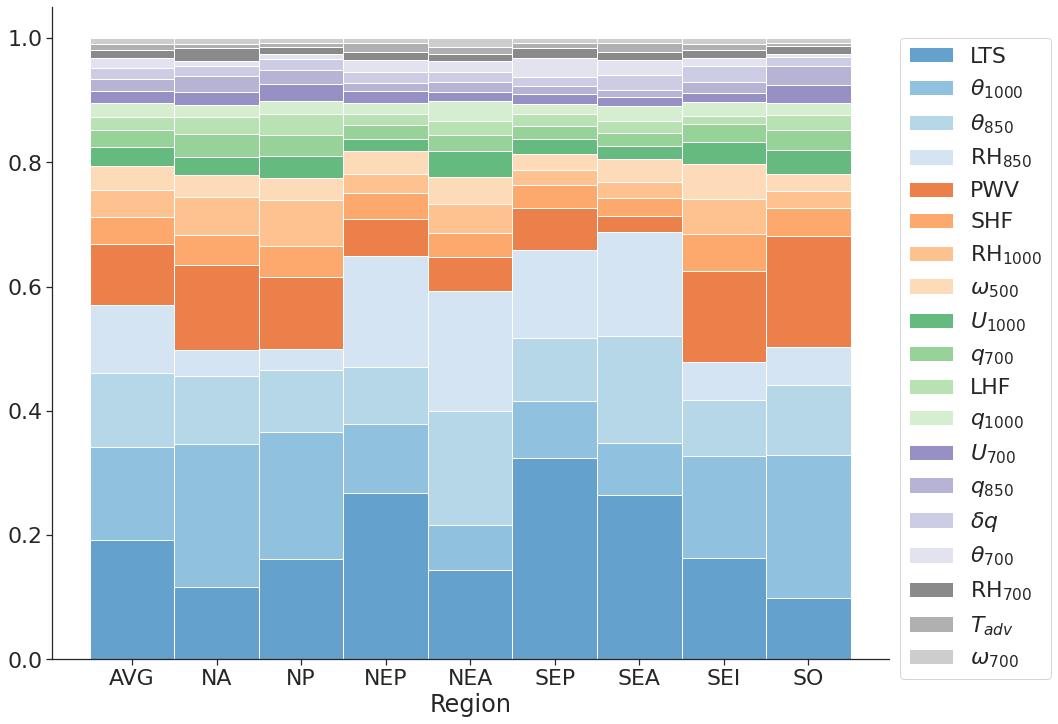

In [20]:

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 2.0)

fig = plt.figure(figsize=[15, 12])

ax = sns.histplot(
    plt_dat,
    x='index',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='value',
    hue='variable',
    multiple='stack',
    palette=list(reversed(sns.color_palette("tab20c", 19))),
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
#    shrink=0.8
    legend=False
)

ax.set_title('')
ax.set_xlabel('Region')
ax.set_ylabel('')

ax.legend(labels_new.labs, loc='upper left', bbox_to_anchor=(1.0, 0.97),
          ncol=1)

plt.show()

In [60]:
# get the relative percentage of shape_value_albsolute_mean for each feature
def get_shapvalues(regs):
    tmp = pd.DataFrame(X_test_scaled, columns=lab)
    #X_sampled = tmp.sample(1000, random_state=10)
    X_sampled = tmp[regs.values]

    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_sampled)
    shap_interaction = explainer.shap_interaction_values(X_sampled)

    mean_shap = np.abs(shap_interaction).mean(0)
    df = pd.DataFrame(mean_shap,index=lab,columns=lab)
    res = pd.Series(np.diagonal(df)/df.values.sum(),index=lab)
    
#    plt.figure(figsize=(30, 30), facecolor='w', edgecolor='k')
#    sns.set(font_scale=1.5)
#    sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.2g',cbar=False)
#    plt.yticks(rotation=0)    
    
    return res


In [61]:
tmp=list(map(get_shapvalues, regs))
res=pd.DataFrame(tmp, index=regs_names)
res_new = res.T
res_new['AVG'] = res_new.mean(axis=1)

lab_seq = res_new['AVG'].sort_values(ascending=False).index
plt_dat = res_new.T.reset_index(level=0).melt(id_vars='index')
plt_dat['variable'] = pd.Categorical(plt_dat['variable'], list(reversed(lab_seq)))
plt_dat['index']    = pd.Categorical(plt_dat['index'], ['AVG']+regs_names)

labels_new = labels.reindex(lab_seq)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


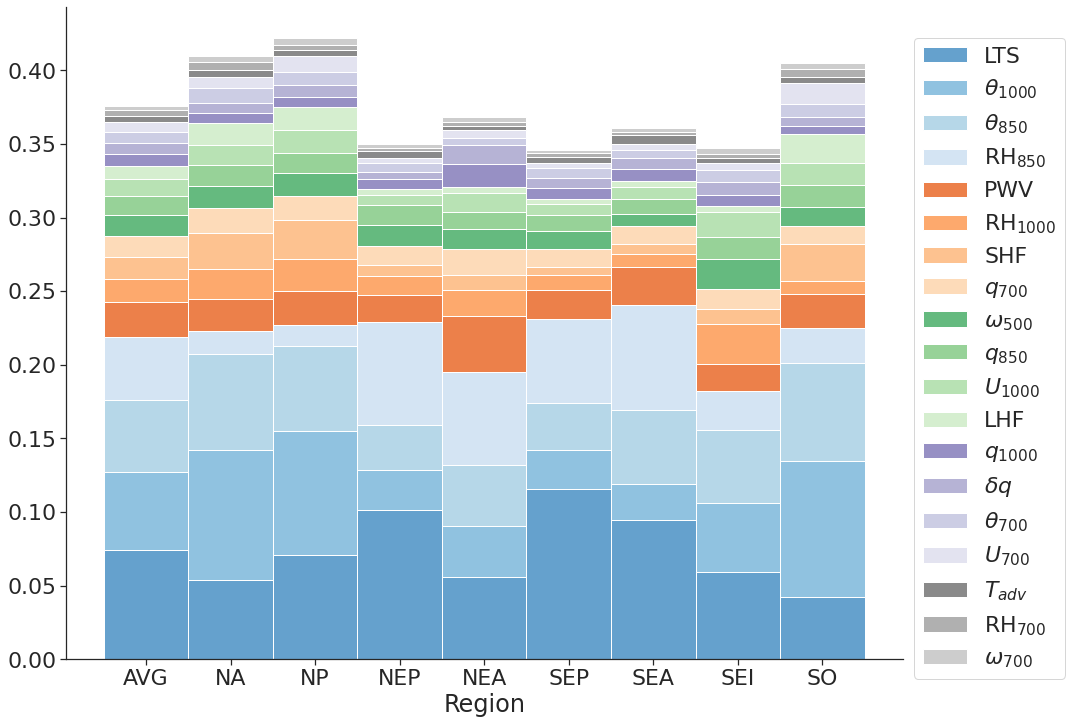

In [62]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 2.0)

fig = plt.figure(figsize=[15, 12])

ax = sns.histplot(
    plt_dat,
    x='index',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='value',
    hue='variable',
    multiple='stack',
    palette=list(reversed(sns.color_palette("tab20c", 19))),
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
#    shrink=0.8
    legend=False
)

ax.set_title('')
ax.set_xlabel('Region')
ax.set_ylabel('')

ax.legend(labels_new.labs, loc='upper left', bbox_to_anchor=(1.0, 0.97),
          ncol=1)

plt.show()